<a href="https://colab.research.google.com/github/Leishaxx/Ecen-project/blob/main/ECEN_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Function to retrieve historical stock data
def get_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

# Define the stock symbol and date range
symbol = "^GSPC"  # S&P 500 index symbol
start_date = "2010-01-01"
end_date = "2024-04-27"

In [ ]:
# Retrieve the stock data
stock_data = get_stock_data(symbol, start_date, end_date)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Preprocess the data
def preprocess_data(data):
    # Select 'Close' column as the target variable
    df = data[['Close']].copy()

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df)

    return df_scaled, scaler


In [ ]:
# Split data into training and testing sets
def split_data(data, train_size=0.8):
    train_size = int(len(data) * train_size)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


In [ ]:
# Prepare data for LSTM model
def prepare_data_for_lstm(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)


In [ ]:
# Define hyperparameters
time_steps = 30  # Number of time steps (days) to look back
batch_size = 64
epochs = 50

# Preprocess the data
data_scaled, scaler = preprocess_data(stock_data)


In [ ]:
# Split data into training and testing sets
train_data, test_data = split_data(data_scaled)

# Prepare data for LSTM
X_train, y_train = prepare_data_for_lstm(train_data, time_steps)
X_test, y_test = prepare_data_for_lstm(test_data, time_steps)

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
45/45 [==============================] - 7s 58ms/step - loss: 0.0127 - val_loss: 0.0011
Epoch 2/50
45/45 [==============================] - 2s 47ms/step - loss: 0.0013 - val_loss: 6.9807e-04
Epoch 3/50
45/45 [==============================] - 2s 54ms/step - loss: 0.0012 - val_loss: 6.2739e-04
Epoch 4/50
45/45 [==============================] - 2s 38ms/step - loss: 0.0011 - val_loss: 6.9544e-04
Epoch 5/50
45/45 [==============================] - 2s 37ms/step - loss: 0.0010 - val_loss: 8.0716e-04
Epoch 6/50
45/45 [==============================] - 2s 37ms/step - loss: 9.9117e-04 - val_loss: 8.1065e-04
Epoch 7/50
45/45 [==============================] - 2s 37ms/step - loss: 0.0010 - val_loss: 7.4061e-04
Epoch 8/50
45/45 [==============================] - 2s 37ms/step - loss: 9.1043e-04 - val_loss: 6.0534e-04
Epoch 9/50
45/45 [==============================] - 2s 47ms/step - loss: 8.3970e-04 - val_loss: 0.0012
Epoch 10/50
45/45 [==============================] - 2s 53ms/step - l

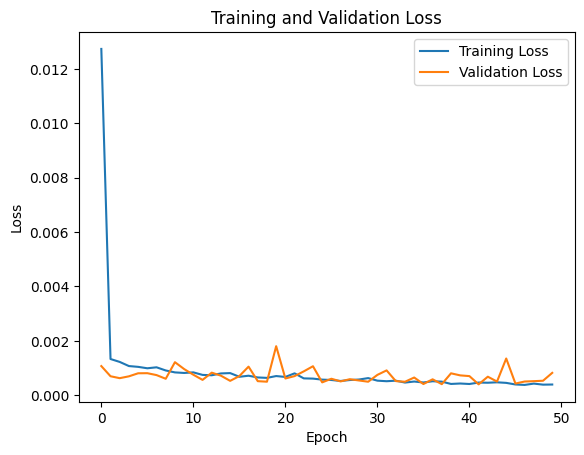

In [ ]:
# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)


22/22 [==============================] - 0s 9ms/step


In [ ]:
# Inverse scale the predictions
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

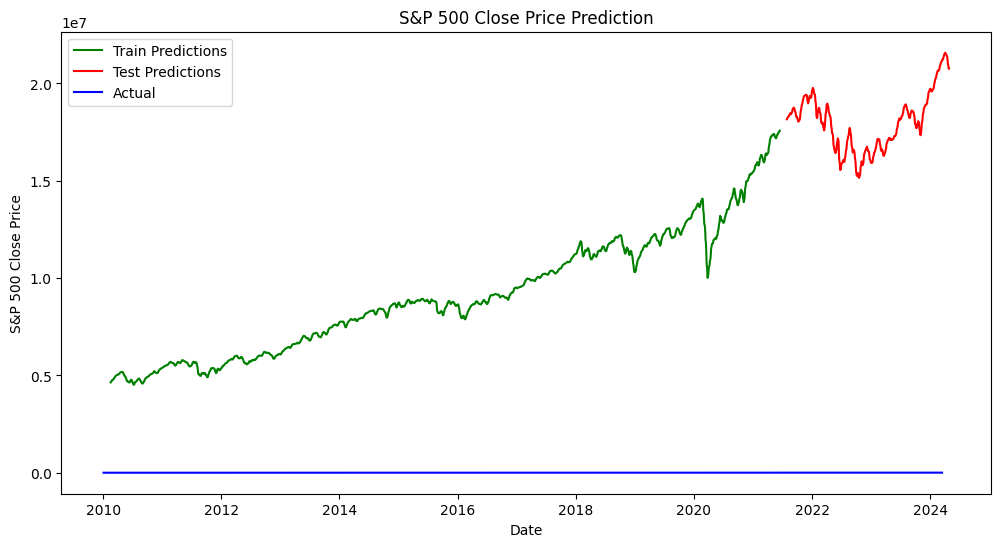

In [ ]:
#train_predictions = train_predictions.reshape(-1, 1)
# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[time_steps:time_steps+len(train_predictions)], train_predictions, color='green', label='Train Predictions')
plt.plot(stock_data.index[-len(test_predictions):], test_predictions, color='red', label='Test Predictions')
plt.plot(stock_data.index[:-time_steps], stock_data['Close'][:-time_steps], color='blue', label='Actual')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.title('S&P 500 Close Price Prediction')
plt.legend()
plt.show()

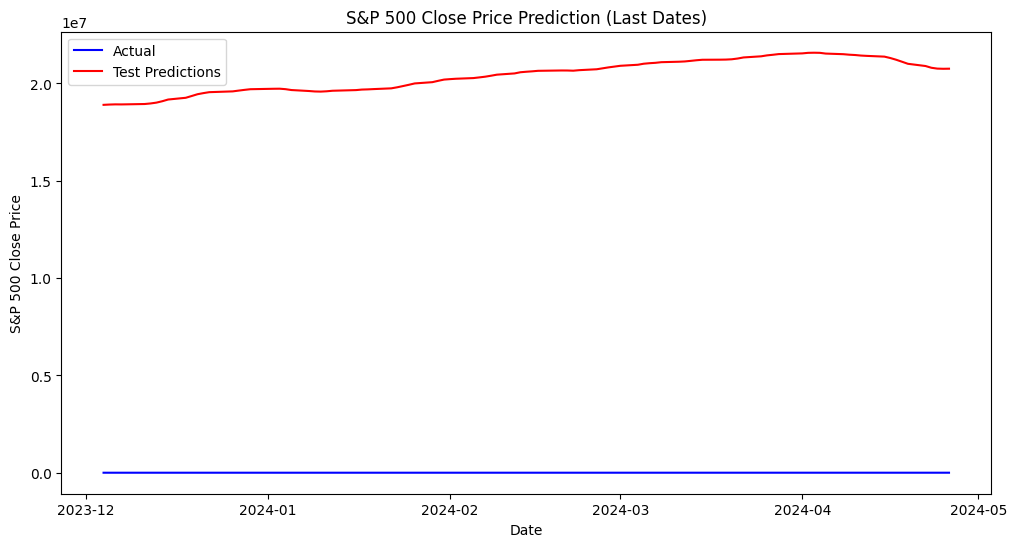

In [ ]:
# Define the number of last dates to plot
num_last_dates = 100  # Adjust as needed

# Plot only the last num_last_dates dates
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[-num_last_dates:], stock_data['Close'][-num_last_dates:], color='blue', label='Actual')
plt.plot(stock_data.index[-num_last_dates:], test_predictions[-num_last_dates:], color='red', label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.title('S&P 500 Close Price Prediction (Last Dates)')
plt.legend()
plt.show()

In [ ]:
num_future_days = 30  # Adjust as needed

# Generate future dates
last_date = stock_data.index[-1]
future_dates = pd.date_range(start=last_date, periods=num_future_days+1)[1:]  # Start from the day after the last available date


In [ ]:
# Prepare data for prediction
last_data_points = data_scaled[-time_steps:]
X_pred = np.array([last_data_points])  # Convert to numpy array and add an extra dimension for batch size


In [ ]:
# Generate predictions
future_predictions_scaled = []
for i in range(num_future_days):
    prediction_scaled = model.predict(X_pred)  # Predict for the next time step
    future_predictions_scaled.append(prediction_scaled)
    # Update X_pred for the next prediction by removing the oldest data point and adding the new prediction
    X_pred = np.concatenate([X_pred[:, 1:, :], prediction_scaled.reshape(1, 1, 1)], axis=1)


1/1 [==============================] - 0s 22ms/step


In [ ]:
# Inverse scale the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))


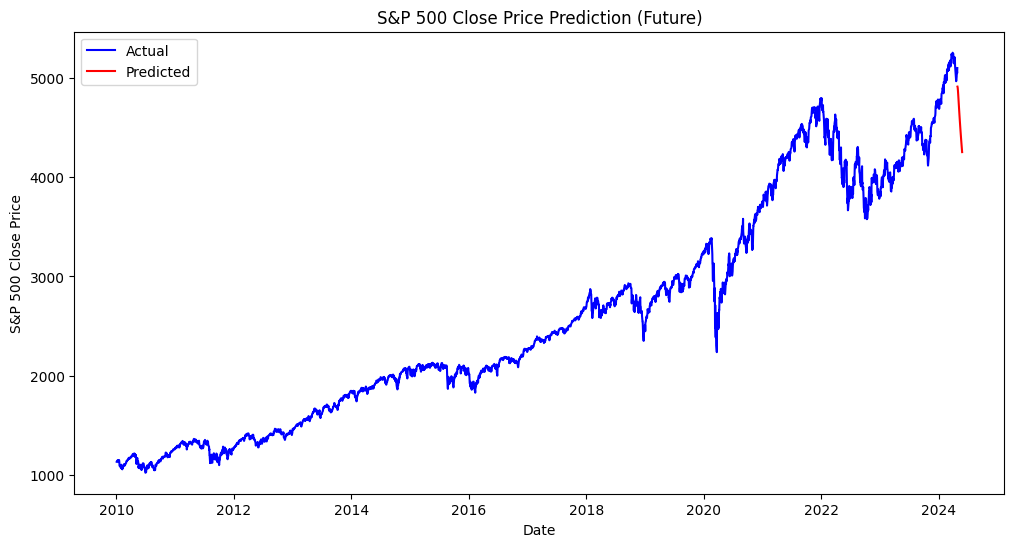

In [ ]:
# Plot actual and predicted future prices
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], color='blue', label='Actual')
plt.plot(future_dates, future_predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.title('S&P 500 Close Price Prediction (Future)')
plt.legend()
plt.show()

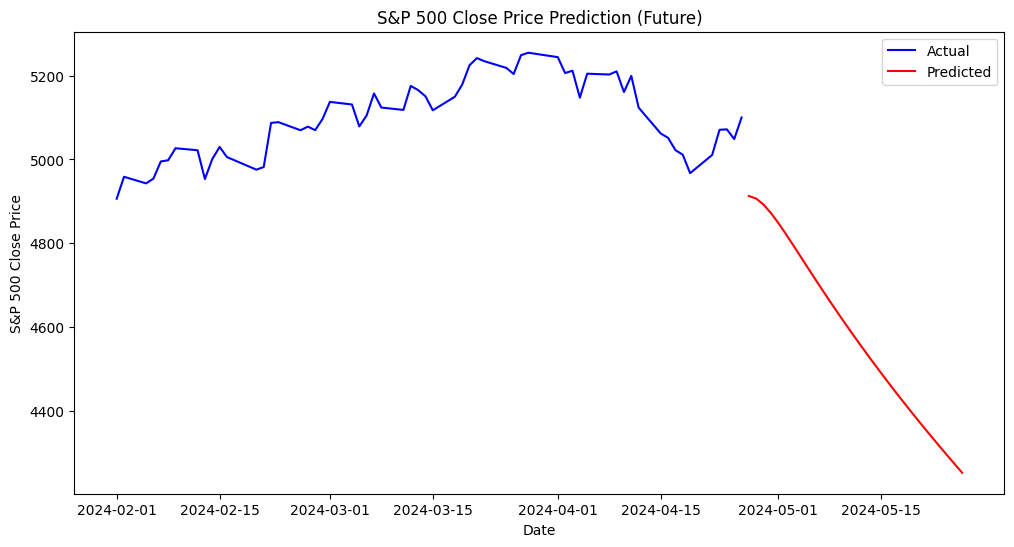

In [ ]:
# Plot actual and predicted future prices
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[-time_steps-num_future_days:], stock_data['Close'][-time_steps-num_future_days:], color='blue', label='Actual')
plt.plot(future_dates, future_predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.title('S&P 500 Close Price Prediction (Future)')
plt.legend()
plt.show()